In [ ]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt


Reference :https://keras.io/examples/structured_data/collaborative_filtering_movielens/

### (1) Load Data

In [ ]:
# Download the actual data from http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
# Use the ratings.csv file
movielens_data_file_url = (
    "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
)
movielens_zipped_file = keras.utils.get_file(
    "ml-latest-small.zip", movielens_data_file_url, extract=False
)
keras_datasets_path = Path(movielens_zipped_file).parents[0]
movielens_dir = keras_datasets_path / "ml-latest-small"

# Only extract the data the first time the script is run.
if not movielens_dir.exists():
    with ZipFile(movielens_zipped_file, "r") as zip:
        # Extract files
        print("Extracting all the files now...")
        zip.extractall(path=keras_datasets_path)
        print("Done!")

ratings_file = movielens_dir / "ratings.csv"
df = pd.read_csv(ratings_file)


In [ ]:
str(ratings_file)

### (2) Processing

In [ ]:
df.head()

In [ ]:
# item to id
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}

In [ ]:
df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

In [ ]:
df.head()

In [ ]:
num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df["rating"] = df["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

In [ ]:
print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

### (3) Prepare training and validation data

In [ ]:
# shuffle
df = df.sample(frac=1, random_state=42)

In [ ]:
x = df[["user", "movie"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
# min max scale
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * df.shape[0])

x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)


In [ ]:
x_train # ( user and movie)

In [ ]:
y_train #( rating )

### (4) Create the model

In [ ]:
EMBEDDING_SIZE = 50


class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super().__init__(**kwargs)
        
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size

        # https://keras.io/api/layers/initializers/#layer-weight-initializers
        # https://zhuanlan.zhihu.com/p/25110150

        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )

        self.user_bias = layers.Embedding(num_users, 1)

        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )

        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])

        #  ? why  what is this for. This seeems useless
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)

        # print(f"dot_user_movie,{dot_user_movie}")
        # print(f"dot_user_movie.shape,{dot_user_movie.shape}")
        # print(f"user_bias.shape,{user_bias.shape}")
        # print(f"movie_bias.shape,{movie_bias.shape}")        
        # Add all the components (including bias)
        
        x = dot_user_movie + user_bias + movie_bias
        x =  user_bias + movie_bias

        # The sigmoid activation forces the rating to between 0 and 1
        # print(f"x.shape,{x.shape}")        

        return tf.nn.sigmoid(x)

In [ ]:
model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
)

### (5) Training

In [17]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
)


1418/1418 [==============================] - 19s 13ms/step - loss: 0.6573 - val_loss: 0.6350
Epoch 2/5
1418/1418 [==============================] - 16s 12ms/step - loss: 0.6207 - val_loss: 0.6165
Epoch 3/5
1418/1418 [==============================] - 16s 12ms/step - loss: 0.6070 - val_loss: 0.6091
Epoch 4/5
1418/1418 [==============================] - 16s 12ms/step - loss: 0.6004 - val_loss: 0.6056
Epoch 5/5
1418/1418 [==============================] - 17s 12ms/step - loss: 0.5967 - val_loss: 0.6037


### (6) Plot training and validation loss

In [21]:
history.history

{'loss': [0.6572816967964172,
  0.6207007169723511,
  0.6069568395614624,
  0.6004254817962646,
  0.5967181921005249],
 'val_loss': [0.635026216506958,
  0.6164676547050476,
  0.6090645790100098,
  0.6055641770362854,
  0.6037321090698242]}

In [22]:
history.history

{'loss': [0.6572816967964172,
  0.6207007169723511,
  0.6069568395614624,
  0.6004254817962646,
  0.5967181921005249],
 'val_loss': [0.635026216506958,
  0.6164676547050476,
  0.6090645790100098,
  0.6055641770362854,
  0.6037321090698242]}

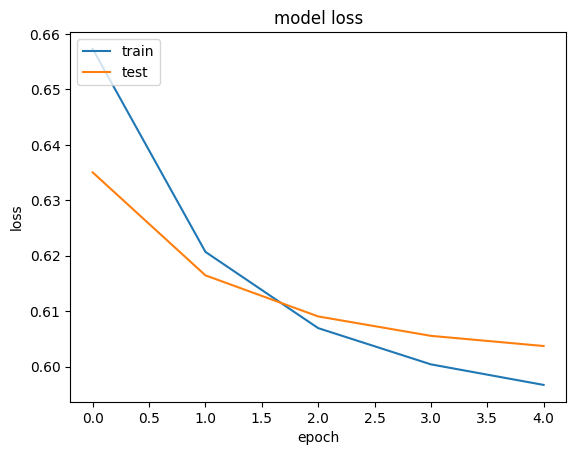

In [23]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()


### (7) Show top 10 movie recommendations to a user

In [24]:
movie_df = pd.read_csv(movielens_dir / "movies.csv")

In [25]:
# Let us get a user and see the top recommendations.
user_id = df.userId.sample(1).iloc[0]

In [26]:
movies_watched_by_user = df[df.userId == user_id]

In [27]:
movies_watched_by_user

,userId,movieId,rating,timestamp,user,movie
93850,599,4351,3.0,1498524542,598,2631
94665,599,59369,2.5,1498518401,598,1911
94895,599,97306,3.0,1498528332,598,4733
94861,599,93723,1.5,1519145934,598,8541
94459,599,31921,2.5,1519185643,598,9126
...,...,...,...,...,...,...
92787,599,393,2.5,1498517496,598,4860
95003,599,122924,2.5,1498529459,598,1083
93426,599,2458,2.0,1519180614,598,1618
94663,599,59315,3.0,1498521596,598,1054


In [28]:
movies_not_watched = movie_df[
    ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
]["movieId"]

In [29]:
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)

In [30]:
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]

In [31]:
user_encoder = user2user_encoded.get(user_id)

In [32]:
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)

In [33]:
user_movie_array

array([[ 598, 5804],
       [ 598,  482],
       [ 598,  483],
       ...,
       [ 598, 3870],
       [ 598, 2989],
       [ 598, 7869]])

In [34]:
ratings = model.predict(user_movie_array).flatten()

227/227 [==============================] - 1s 2ms/step


In [35]:
top_ratings_indices = ratings.argsort()[-10:][::-1]

In [36]:
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

In [37]:
print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)

Showing recommendations for user: 599
Movies with high ratings from user
--------------------------------
Paths of Glory (1957) : Drama|War
Fight Club (1999) : Action|Crime|Drama|Thriller
Yojimbo (1961) : Action|Adventure
Road Warrior, The (Mad Max 2) (1981) : Action|Adventure|Sci-Fi|Thriller
Kill Bill: Vol. 1 (2003) : Action|Crime|Thriller
--------------------------------
Top 10 movie recommendations
--------------------------------
Schindler's List (1993) : Drama|War
Vertigo (1958) : Drama|Mystery|Romance|Thriller
North by Northwest (1959) : Action|Adventure|Mystery|Romance|Thriller
One Flew Over the Cuckoo's Nest (1975) : Drama
12 Angry Men (1957) : Drama
Cool Hand Luke (1967) : Drama
This Is Spinal Tap (1984) : Comedy
Life Is Beautiful (La Vita è bella) (1997) : Comedy|Drama|Romance|War
Finding Nemo (2003) : Adventure|Animation|Children|Comedy
In Bruges (2008) : Comedy|Crime|Drama|Thriller


### (8) Explore to learn

In [38]:
user_embedding = layers.Embedding(
            1000,
            128,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )

In [39]:
movie_embedding = layers.Embedding(
            1000,
            128,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )

In [40]:
inputs = x_train[:64]

In [41]:
user_vector = user_embedding(inputs[:, 0])

In [42]:
user_vector.shape

TensorShape([64, 128])

In [43]:
movie_vector = movie_embedding(inputs[:, 1])

In [44]:
movie_vector.shape

TensorShape([64, 128])

In [45]:
dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)

In [46]:
dot_user_movie.shape

TensorShape([])

In [47]:
dot_user_movie + dot_user_movie

<tf.Tensor: shape=(), dtype=float32, numpy=0.11006874>

In [48]:
user_bias = layers.Embedding(1000, 1)

movie_bias = layers.Embedding(1000, 1)

In [49]:
user_bias_vector = user_bias(inputs[:, 0])